In [34]:
# Standard library packages
import io

# Import bioservices module, to run remote UniProt queries
from bioservices import UniProt

# Import Pandas, so we can use dataframes
import pandas as pd

# Make a link to the UniProt webservice
service = UniProt()

# Build a query string - looking for EC 3.X.X.X
query = "ec:3*"

# Define a list of columns we want to retrieve - print(service._valid_columns)
columnlist = "accession,ec,xref_pdb,ft_act_site,sequence"

# Run the remote search
result = service.search(query, frmt="tsv", columns=columnlist, limit=10000)

# Check if result is empty or None
if result is None or not result.strip():
    print("No data returned from UniProt query. Skipping further processing.")
else:
    # Convert the result into a dataframe in Pandas
    df = pd.read_table(io.StringIO(result))
    
    # New df with NaN lines removed
    df_new = df.dropna()
    
    # Use regular expression to pull out the active site values
    extracted_numbers = df_new['Active site'].str.extractall(r'ACT_SITE\s+(\d+)')
    
    # Group active site back into each row
    grouped_numbers = extracted_numbers[0].groupby(level=0).apply(list)
    
    # Rewrite active site column to just be numbers
    df_new.loc[:, 'Active site'] = grouped_numbers
    
    # Save to Excel file
    df_new.to_excel("withseq.xlsx")

WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
ERROR   [bioservices.UniProt:731]:  No results found


No data returned from UniProt query. Skipping further processing.


In [37]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd

# Read the Excel file
df = pd.read_excel('withseq_clean.xlsx')

# Function to calculate amino acid frequencies from a sequence
def calculate_aa_frequencies(sequence):
    if isinstance(sequence, str):
        analysis = ProteinAnalysis(sequence)
        aa_frequencies = analysis.count_amino_acids()
        total_aa = sum(aa_frequencies.values())
        aa_frequencies_normalized = {aa: freq / total_aa for aa, freq in aa_frequencies.items()}
        return aa_frequencies_normalized
    else:
        return None

# Filter out missing values in the 6th column
sequences = df.iloc[:, 5].dropna()

# Calculate amino acid frequencies for each sequence
aa_frequencies_data = sequences.apply(calculate_aa_frequencies)

# Add amino acid frequencies to the 8th column of the DataFrame
df.loc[sequences.index, 'Amino Acid Frequencies'] = aa_frequencies_data

# Write the modified DataFrame to an Excel file
df.to_excel('output_with_aa_frequencies.xlsx', index=False)

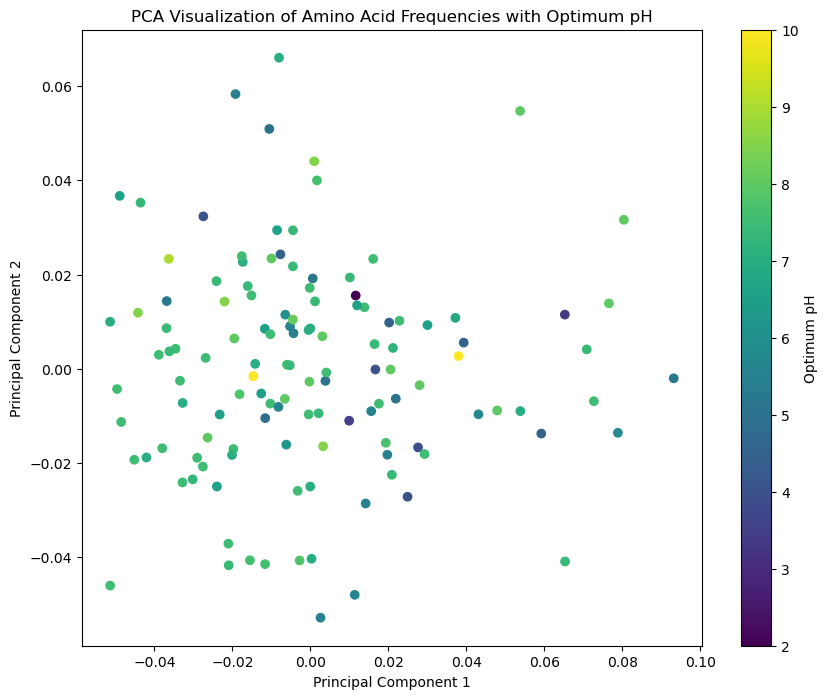

In [46]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Read the Excel file
df = pd.read_excel('withseq_ph_frequencies.xlsx')

# Extract amino acid frequencies and pH values
X_frequencies = df.iloc[:, 7:]  # Assuming amino acid frequencies start from the 8th column
y_pH = df.iloc[:, 6]  # Assuming pH is in the 7th column

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_frequencies)

# Create a scatter plot of the PCA representation
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pH, cmap='viridis')
plt.colorbar(label='Optimum pH')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Amino Acid Frequencies with Optimum pH')
plt.show()